# Azores high: analysis
The analysis is divided into three parts:
1. __"Observed" expansion and model validation__: we'll plot the "observed" expansion of the Azores High – based on reanalysis output – and compare it to the expansion simulated by the CESM-LME over the overlapping period (approximately 1850-2005). The motivating question is: can we trust the model over the period where it *doesn't* overlap with observations?
2. __Time series analysis of model output and comparison to paleo record__: we'll compare statistics between CESM-LME ensembles with different "external forcing". In particular, we'll look at four types of forcing: (a) greenhouse gas emissions, (b) orbital/solar variability, (c) volcanic activity, and (d) all of the above (denoted "Full" in the paper). We'll also compare the Azores High variability "Full" forcing scenario to the $\delta^{13}C$ variability in the Portuguese stalagmite.
3. __Significance testing__: we'll use a Monte-Carlo approach to test for statistical significance of the detected Azores High expansion.

To run the notebook, download the pre-computed Azores High Area (AHA) index here: [https://drive.google.com/drive/folders/105TW_8MNUMddEIHKYPgou0iXKG8ZsCNd?usp=sharing](https://drive.google.com/drive/folders/105TW_8MNUMddEIHKYPgou0iXKG8ZsCNd?usp=sharing).

## Packages

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import pathlib

## Set plotting defaults
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## Utility functions

In [2]:
def get_empirical_pdf(x, bin_edges=None):
    """
    Estimate the "empirical" probability distribution function for the data x.
    In this case the result is a normalized histogram,
    Normalized means that integrating over the histogram yields 1.
    Returns the PDF (normalized histogram) and edges of the histogram bins
    """

    ## compute histogram
    if bin_edges is None:
        hist, bin_edges = np.histogram(x)

    else:
        hist, _ = np.histogram(x, bins=bin_edges)

    ## normalize to a probability distribution (PDF)
    bin_width = bin_edges[1:] - bin_edges[:-1]
    pdf = hist / (hist * bin_width).sum()

    return pdf, bin_edges

## Load data

````{admonition} To-do
Below, specify the folder where the AHA data is saved (i.e., set the variable called ```AHA_save_fp```). The AHA data can be downloaded here: [https://drive.google.com/drive/folders/105TW_8MNUMddEIHKYPgou0iXKG8ZsCNd?usp=sharing](https://drive.google.com/drive/folders/105TW_8MNUMddEIHKYPgou0iXKG8ZsCNd?usp=sharing).
````

In [3]:
## where is the data saved?
AHA_save_fp = pathlib.Path("data/AHA")

Load the data

In [4]:
def load_AHA(save_fp):
    """Load AHA data from given directory"""

    ## names of datasets
    names = ["era", "noaa", "lme_full", "lme_orb", "lme_volc", "lme_GHG"]

    ## function to get absolute path to dataset
    get_fp = lambda name: pathlib.Path(AHA_save_fp, f"AHA_{name}.nc")

    ## function to open single dataset and rename it
    open_single = lambda name: xr.open_dataarray(get_fp(name)).rename(name)

    return xr.merge([open_single(name) for name in names])


## Load the data
aha = load_AHA(AHA_save_fp)

### LME model validation (Fig 2c)
Metric: 25-year rolling count of AHA extremes

In [5]:
def count_extremes(AHA, cutoff_perc=90.0, window=25):
    """Get rolling count of Azores High extreme events.
    Args:
    - cutoff_perc is percentile value in range (0 and 100) used to define
        'extreme' events
    - window is an integer specifying how many years the rolling window is.
    """

    ## get threshold for extreme events
    threshold = AHA.quantile(q=cutoff_perc / 100)

    ## Get boolean array: True if AHA exceeds thresh
    exceeds_thresh = AHA > threshold

    ## put NaNs back in the array
    exceeds_thresh = exceeds_thresh.where(~np.isnan(AHA))

    ## Get rolling count
    rolling_kwargs = dict(dim={"year": window}, center=True, min_periods=10)
    rolling_count = exceeds_thresh.rolling(**rolling_kwargs).mean() * window

    return rolling_count

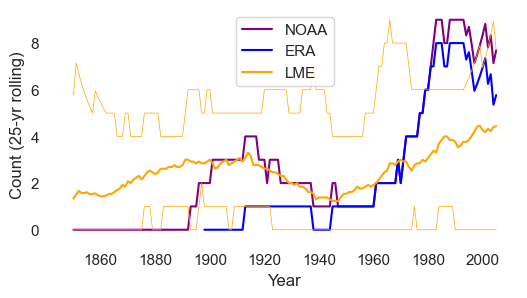

In [6]:
## count extremes (from 1850-2005)
extreme_count = count_extremes(aha.sel(year=slice(1850, 2005)))

## make plot
fig, ax = plt.subplots(figsize=(6, 3))

## plot reanalysis
ax.plot(extreme_count.year, extreme_count["noaa"], label="NOAA", c="purple")
ax.plot(extreme_count.year, extreme_count["era"], label="ERA", c="blue")

# ## plot LME mean and min/max range
ax.plot(
    extreme_count.year,
    extreme_count["lme_full"].mean("ensemble_member"),
    label="LME",
    c="orange",
)
ax.plot(
    extreme_count.year,
    extreme_count["lme_full"].max("ensemble_member"),
    c="orange",
    lw=0.5,
)
ax.plot(
    extreme_count.year,
    extreme_count["lme_full"].min("ensemble_member"),
    c="orange",
    lw=0.5,
)

# ax.plot(rolling_count.year, rolling_count["era"])

## label plot
ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Count (25-yr rolling)")
plt.show()

### LME single-forcing comparison (Fig 3d,3e)

#### Functions for loading paleo data and binning by century

In [7]:
def load_paleo_data():
    """
    Function to load Paleo data. Description of data here:
    https://www.ncei.noaa.gov/access/paleo-search/study/37160
    """

    ## data is located at following link:
    fp = r"https://www.ncei.noaa.gov/pub/data/paleo/speleothem/europe/portugal/thatcher2022/thatcher2022-composite_isotope_records.txt"

    ## open dataset using Pandas
    paleo_data = pd.read_csv(fp, skiprows=117, sep=r"\s+").set_index("age_CE")

    ## convert to xarray and rename coordinate "year"
    paleo_data = paleo_data.to_xarray().rename({"age_CE": "year"})

    ## switch order of year coordinate so that it's increasing
    paleo_data = paleo_data.reindex({"year": paleo_data.year.values[::-1]})

    return paleo_data


def floor_nearest100(x):
    """rounds down to nearest 100"""

    return np.floor(x / 100) * 100


def bin_by_century(data, bin_offset=0):
    """
    Function to bin data by century. Args:
    - 'bin_offset' is number in [0, 100) representing
        where the first bin begins.
    """

    ## Get century to label data with
    century = floor_nearest100(data["year"] - bin_offset) + bin_offset

    ## add century as new coordinate on data
    ## (this makes it easy to group data by century)
    data = data.assign_coords({"century": century.astype(int)})

    # get mean for each century
    data_binned = data.groupby("century").mean()

    return data_binned

#### Compute stats

In [8]:
## Load paleo data
paleo_data = load_paleo_data()

## Get count of extremes on full LME simulation (100-year window)
extreme_count_100 = count_extremes(
    aha.drop_vars(["era", "noaa"]), window=100, cutoff_perc=90
)

## Compute binned average for paleo data
offset = 25  # the first bin begins at year (800 + offset)
paleo_data_binned = bin_by_century(paleo_data, bin_offset=offset)

## compute binned average for AHA ensemble mean
aha_mean_binned = bin_by_century(aha.mean("ensemble_member"), bin_offset=offset)

## combined binned data into single DataArray
data_binned = xr.merge([paleo_data_binned, aha_mean_binned])

#### Plotting functions

In [9]:
def plot_LME_extremes(ax, extreme_count):
    """function to plot LME extremes on ax object"""

    ## specify colors and linestyles for each LME run
    varnames = ["lme_full", "lme_GHG", "lme_volc", "lme_orb"]
    labels = ["Full", "GHG", "Volcanic", "Solar"]
    colors = ["k", "green", "red", "orange"]
    scales = [1, 0.75, 0.5, 0.5]

    ## Plot lines one-by-one
    for label, varname, color, scale in zip(labels, varnames, colors, scales):

        ## get linewidth based on scale
        mean_width = 2.0 * scale
        range_width = 0.5 * scale

        ## plot ensemble mean
        ax.plot(
            extreme_count.year,
            extreme_count[varname].mean("ensemble_member", skipna=True),
            label=label,
            c=color,
            lw=mean_width,
        )

    ## plot standard deviation for "Full" run
    mean_ = extreme_count["lme_full"].mean("ensemble_member")
    std_ = extreme_count["lme_full"].std("ensemble_member")
    ax.fill_between(
        extreme_count.year, mean_ + std_, mean_ - std_, color="k", alpha=0.07
    )

    ## label plot
    ax.legend(prop={"size": 8})
    ax.set_xlabel("Year")
    ax.set_ylabel("Extreme events")
    ax.set_yticks([5, 10, 15, 20])
    # ax.set_ylim([None, 20])

    return ax


def plot_paleo_comparison(ax, data_binned):
    """function to plot paleo data and AHA over time"""

    ## get edges of bins (used for plotting)
    bin_starts = data_binned.century.values
    bin_edges = np.insert(bin_starts, obj=len(bin_starts), values=bin_starts[-1] + 100)

    ## get color for paleo plot
    color_paleo = sns.color_palette()[0]

    ## plot paleo data first
    paleo_plot = ax.stairs(data_binned["d13C_compSuess"], bin_edges, color=color_paleo)
    ax.set_ylabel(r"$\delta^{13}C$", c=color_paleo)
    ax.set_yticks([-1, -2, -3], labels=[-1, -2, -3], color=color_paleo)
    ax.set_xlim([830, 2020])

    ## plot AHA on same x-axis
    ax1 = ax.twinx()
    ax1.stairs(data_binned["lme_full"], bin_edges, color="k")
    ax1.set_ylabel(r"Azores area ($km^2$)")
    ax1.set_yticks([9e6, 11e6, 13e6])
    ax1.set_ylim([9e6, 14e6])

    return ax, ax1

#### Make plot:

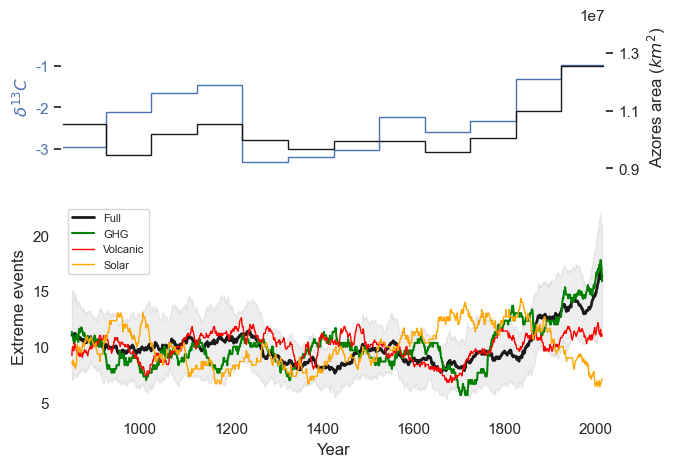

In [10]:
fig = plt.figure(figsize=(7, 5))
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[0.7, 1])

## plot binned paleo data and AHA over time
ax0 = fig.add_subplot(gs[0])
ax00, ax01 = plot_paleo_comparison(ax0, data_binned)
ax00.set_xticks([])

## Plot extreme count over time
ax1 = fig.add_subplot(gs[1])
ax1 = plot_LME_extremes(ax1, extreme_count_100)

## make sure x-axes match
ax1.set_xlim(ax0.get_xlim())

plt.show()

### Azores High distribution shift (Fig. 3b)

Split data into pre- and post-industrial, and compute PDFs

In [11]:
## split data into pre-industrial control and historical
aha_PI = aha["lme_full"].sel(year=slice(None, 1850))
aha_hist = aha["lme_full"].sel(year=slice(1851, 2005))

## compute PDFs
pdf_PI, edges = get_empirical_pdf(aha_PI.values.flatten())
pdf_hist, _ = get_empirical_pdf(aha_hist.values.flatten())

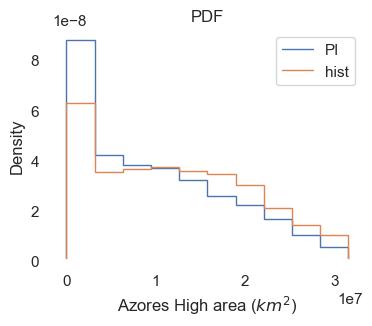

In [12]:
#### Plot result
fig, ax = plt.subplots(figsize=(4, 3))

## plot histogram
ax.stairs(values=pdf_PI, edges=edges, label="PI")
ax.stairs(values=pdf_hist, edges=edges, label="hist")

## label
ax.set_xlabel(r"Azores High area ($km^{2}$)")
ax.set_ylabel("Density")

ax.legend()
ax.set_title("PDF")

plt.show()

### PDF of extreme events (Fig. 3c)

In [48]:
## drop the first/last 50 years (so we only have samples with full 100-yr windows)
extreme_count_nonan = extreme_count_100["lme_full"].sel(year=slice(851 + 50, 2005 - 50))

## Let's create a "sample pool" to draw from
## we'll leave out the last 50 years of data (we'll compare to the sample pool later)
sample_pool = extreme_count_nonan.isel(year=slice(None, -50))
sample_pool = sample_pool.stack(sample=["year", "ensemble_member"])

#### generate a random sequence of sample indices to generate a Monte-Carlo PDF

## first, initialize a random number generator and generate random indices
rng = np.random.default_rng()
rand_idx = rng.choice(len(sample_pool.sample), size=int(13 * 1e5))

## next, pull the random samples
rand_samples = sample_pool.values[rand_idx]

## also create an artificial "ensemble mean"
# rand_samples_ens_mean = rand_samples.reshape(13, -1).mean(0)

## second version
rand_years = rng.choice(extreme_count_nonan.year.values[:-50], size=int(1e5), replace=True)
rand_samples_ens_mean = extreme_count_nonan.sel(year=rand_years).mean("ensemble_member")

In [51]:
extreme_count_nonan

(13, 1055)

In [71]:
def monte_carlo_frequency(n_iterations, bool_array, auto=None):
        
    #initialize array to hold the number of events occuring in each sample 
    n_true = np.zeros(n_iterations)
            
    for i in tqdm.tqdm(range(0,n_iterations)):
        
        n_true_temp = np.zeros(13)
        
        for j in range(0,13):
            
            start = rng.choice(bool_array.shape[1])
            
            n_true_temp[j] = bool_array[j,start]
            
        n_true[i]= n_true_temp.sum()
        
    return n_true

In [72]:
import tqdm

In [76]:
f = monte_carlo_frequency(n_iterations=100000, bool_array = extreme_count_nonan.values)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [00:08<00:00, 12464.28it/s]


In [78]:
f/13

array([ 8.30769231,  9.15384615, 10.30769231, ...,  8.15384615,
       10.15384615, 10.38461538])

#### PDF for individual samples

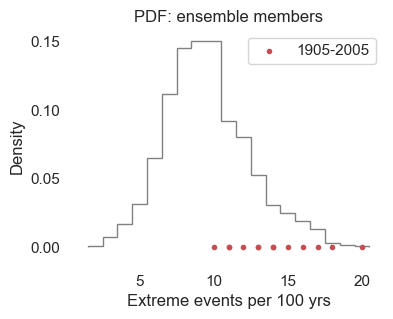

In [85]:
## specify bin edges
pdf, edges = get_empirical_pdf(rand_samples, np.arange(1.5, 21.5, 1))  # .values)
# pdf_, _ = get_empirical_pdf(extreme_count_nonan.isel(year=slice(None,-50)).values.flatten(), np.arange(1.5, 21.5, 1))

#### Plot result
fig, ax = plt.subplots(figsize=(4, 3))

## plot histogram
ax.stairs(values=pdf, edges=edges, color="gray")
# ax.stairs(values=pdf_, edges=edges, color="red")

# plot samples from last 100 years
ax.scatter(
    extreme_count_nonan.isel(year=-1),
    np.zeros(len(extreme_count_nonan.ensemble_member)),
    marker=".",
    c="r",
    label="1905-2005",
)

## label
ax.set_xlabel(r"Extreme events per 100 yrs")
ax.set_ylabel("Density")
ax.set_title("PDF: ensemble members")
ax.set_yticks([0, 0.05, 0.1, 0.15])
ax.set_ylim([-0.01, None])
ax.legend()

plt.show()

#### PDF for ensemble mean

(array([    0.,  7688.,  7664., 15317.,  7694.,  7784.,  7729., 15534.,
         7614.,  7688., 15288.,     0.,     0.,     0.]),
 array([-0.625, -0.525, -0.425, -0.325, -0.225, -0.125, -0.025,  0.075,
         0.175,  0.275,  0.375,  0.475,  0.575,  0.675,  0.775]),
 <BarContainer object of 14 artists>)

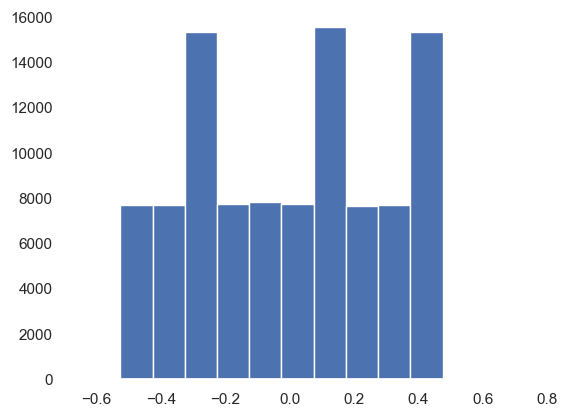

In [103]:
plt.hist(f/13-np.round(f/13), bins=np.arange(-.625,.875,.1))

In [90]:
rand_samples_ens_mean

<xarray.DataArray 'lme_full' (year: 100000)> Size: 800kB
array([10.30769231, 11.07692308,  8.69230769, ...,  8.69230769,
       10.15384615,  9.46153846])
Coordinates:
  * year      (year) int64 800kB 1149 1233 1311 1099 ... 1091 1832 1143 1763
    quantile  float64 8B 0.9

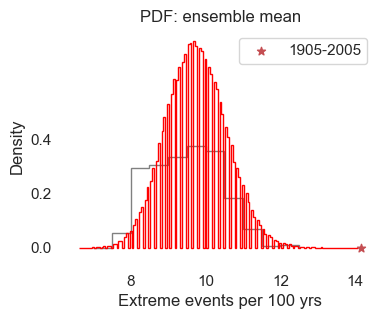

In [109]:
## specify bin edges
pdf, edges = get_empirical_pdf(rand_samples_ens_mean, bin_edges=np.arange(7, 13, 0.5))
# pdf_, _ = get_empirical_pdf(extreme_count_nonan.mean("ensemble_member"), bin_edges=np.arange(7, 13, 0.5))
pdf_, edges_ = get_empirical_pdf(f/13, bin_edges=np.arange(6.625, 14.125, 0.05))

#### Plot result
fig, ax = plt.subplots(figsize=(4, 3))

## plot histogram
ax.stairs(values=pdf, edges=edges, color="gray")
ax.stairs(values=pdf_, edges=edges_, color="red")

# plot samples from last 100 years
ax.scatter(
    extreme_count_nonan.isel(year=-1).mean("ensemble_member"),
    0,
    marker="*",
    c="r",
    label="1905-2005",
)

## label
ax.set_xlabel(r"Extreme events per 100 yrs")
ax.set_ylabel("Density")
ax.set_title("PDF: ensemble mean")
ax.set_yticks([0, 0.2, 0.4])
ax.set_ylim([-0.05, None])
# ax.set_xlim([9.5,9.9])
ax.legend()

plt.show()

In [30]:
help(rng.choice)

Help on method choice in module numpy.random._generator:

choice(a, size=None, replace=True, p=None, axis=0, shuffle=True) method of numpy.random._generator.Generator instance
    choice(a, size=None, replace=True, p=None, axis=0, shuffle=True)
    
    Generates a random sample from a given array
    
    Parameters
    ----------
    a : {array_like, int}
        If an ndarray, a random sample is generated from its elements.
        If an int, the random sample is generated from np.arange(a).
    size : {int, tuple[int]}, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn from the 1-d `a`. If `a` has more
        than one dimension, the `size` shape will be inserted into the
        `axis` dimension, so the output ``ndim`` will be ``a.ndim - 1 +
        len(size)``. Default is None, in which case a single value is
        returned.
    replace : bool, optional
        Whether the sample is with or without replaceme